# Image recognition of Anderson states

## Preliminaries

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
print(torch.__version__)
# device=torch.device
# # if torch.cuda.is_available():
# #     device = torch.device("cuda:0")
# print('chosen device: ',device)

1.4.0


In [3]:
from fastai.vision import *
from fastai.metrics import error_rate

In [4]:
#bs = 64
bs = 16  # uncomment this line if you run out of memory even after clicking Kernel->Restart
myepoch0 = 4
myepoch1 = 2
myepoch2 = 2

## Reading in the image data

In [5]:
path = Path('/storage/disqs/ML-Anderson3D/Images/L20-5000-s100')

In [6]:
path.ls()

[PosixPath('/storage/disqs/ML-Anderson3D/Images/L20-5000-s100/W16.6'),
 PosixPath('/storage/disqs/ML-Anderson3D/Images/L20-5000-s100/W15.5'),
 PosixPath('/storage/disqs/ML-Anderson3D/Images/L20-5000-s100/W15.25'),
 PosixPath('/storage/disqs/ML-Anderson3D/Images/L20-5000-s100/W17.25'),
 PosixPath('/storage/disqs/ML-Anderson3D/Images/L20-5000-s100/models'),
 PosixPath('/storage/disqs/ML-Anderson3D/Images/L20-5000-s100/W16.5'),
 PosixPath('/storage/disqs/ML-Anderson3D/Images/L20-5000-s100/W18.0'),
 PosixPath('/storage/disqs/ML-Anderson3D/Images/L20-5000-s100/W17.5'),
 PosixPath('/storage/disqs/ML-Anderson3D/Images/L20-5000-s100/W16.8'),
 PosixPath('/storage/disqs/ML-Anderson3D/Images/L20-5000-s100/W16.2'),
 PosixPath('/storage/disqs/ML-Anderson3D/Images/L20-5000-s100/W16.0'),
 PosixPath('/storage/disqs/ML-Anderson3D/Images/L20-5000-s100/W15.75'),
 PosixPath('/storage/disqs/ML-Anderson3D/Images/L20-5000-s100/W17.75'),
 PosixPath('/storage/disqs/ML-Anderson3D/Images/L20-5000-s100/W17.0'),
 

In [7]:
np.random.seed(1234567)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(do_flip=False,max_rotate=0.,max_warp=0.,max_zoom=1.0,max_lighting=None), 
                                  size=256, num_workers=4).normalize(imagenet_stats)

In [8]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['W15.0',
  'W15.25',
  'W15.5',
  'W15.75',
  'W16.0',
  'W16.2',
  'W16.3',
  'W16.4',
  'W16.5',
  'W16.6',
  'W16.7',
  'W16.8',
  'W17.0',
  'W17.25',
  'W17.5',
  'W17.75',
  'W18.0'],
 17,
 68000,
 17000)

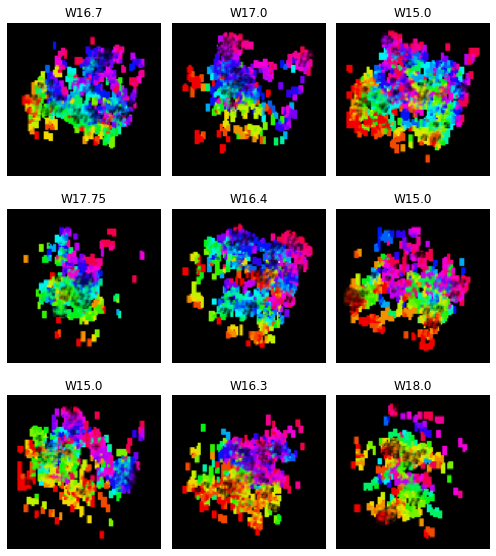

In [9]:
data.show_batch(rows=3, figsize=(7,8))

## Train model

In [10]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate, pretrained=False)#.to_fp16()

In [11]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [12]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 128, 128]       9,408      True      
______________________________________________________________________
BatchNorm2d          [64, 128, 128]       128        True      
______________________________________________________________________
ReLU                 [64, 128, 128]       0          False     
______________________________________________________________________
MaxPool2d            [64, 64, 64]         0          False     
______________________________________________________________________
Conv2d               [64, 64, 64]         36,864     True      
______________________________________________________________________
BatchNorm2d          [64, 64, 64]         128        True      
______________________________________________________________________
ReLU                 [64, 64, 64]         0          False     
___________________________________________________

In [ ]:
learn.lr_find()
learn.recorder.plot()
learn.recorder.plot_lr()

epoch,train_loss,valid_loss,error_rate,time


In [ ]:
lr=1.e-2

In [ ]:
learn.fit_one_cycle(myepoch0,lr)

In [ ]:
learn.save('stage-0')

In [ ]:
learn.show_results()

In [ ]:
learn.lr_find()
learn.recorder.plot()
learn.recorder.plot_lr()

## Heatmap

In [ ]:
idx=0
x,y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]

In [ ]:
m = learn.model.eval();

In [ ]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [ ]:
from fastai.callbacks.hooks import *

In [ ]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [ ]:
hook_a,hook_g = hooked_backward()

In [ ]:
acts  = hook_a.stored[0].cpu()
acts.shape

In [ ]:
avg_acts = acts.mean(0)
avg_acts.shape

In [ ]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,256,256,0),
              interpolation='bilinear', cmap='magma');

In [ ]:
show_heatmap(avg_acts)

## refining the model - stage 1

In [ ]:
learn.load('stage-0');

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()
#learn.recorder.plot_losses()
# learn.recorder.plot_lr()

In [ ]:
learn.fit_one_cycle(myepoch1, max_lr=slice(3e-6,3e-4))

In [ ]:
learn.save('stage-1')

## refining the model further - stage 2

In [ ]:
learn.load('stage-1');
learn.unfreeze();
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(myepoch2, max_lr=slice(3e-6,1e-5))

In [ ]:
learn.save('stage-2')

## Interpretation

In [ ]:
learn.load('stage-0');

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.plot_confusion_matrix(figsize=(10,10))

In [ ]:
learn.load('stage-1');

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.plot_confusion_matrix(figsize=(10,10))

In [ ]:
learn.load('stage-2');

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.plot_confusion_matrix(figsize=(10,10))